<a href="https://colab.research.google.com/github/yutao-data/Sepsis_Gene_KnowledgeGraph_Ontology/blob/main/Sepsis_Pathways.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gprofiler
!pip install GEOparse
!pip install owlready2
!pip install gprofiler-official
!pip install pyvis

In [ ]:
import requests
from gprofiler import GProfiler
import GEOparse
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
from owlready2 import *
import warnings
from itertools import combinations
from io import StringIO
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

## Import Data

In [ ]:
warnings.filterwarnings("ignore")

onto = get_ontology("http://purl.obolibrary.org/obo/go.owl").load()
ppio_ontology = get_ontology("/content/drive/MyDrive/stagelisn2024-main/PPI_Onto.owl").load()
onto.imported_ontologies.append(ppio_ontology)

In [ ]:
# Load GPL annotations
gpl_annotations = pd.read_csv("/content/drive/MyDrive/stagelisn2024-main/data/GPL6947-13512.txt", sep="\t", comment='#')

# Map probes to gene IDs
probe_to_gene = gpl_annotations[['ID', 'Entrez_Gene_ID']]
probe_to_gene = probe_to_gene.dropna(subset=['Entrez_Gene_ID'])
probe_to_gene['Entrez_Gene_ID'] = probe_to_gene['Entrez_Gene_ID'].astype(int)

probe_to_gene.head()

,ID,Entrez_Gene_ID
0,ILMN_1725881,23117
2,ILMN_1804174,2213
3,ILMN_1796063,54765
4,ILMN_1811966,653895
5,ILMN_1668162,158833


In [ ]:
# Load GEO dataset
gse = GEOparse.get_GEO(filepath="/content/drive/MyDrive/stagelisn2024-main/data/GSE54514_family.soft.gz", silent=True)

expression_data = pd.DataFrame()
for gsm_name, gsm in gse.gsms.items():
    expression_data[gsm_name] = gsm.table.set_index("ID_REF")["VALUE"]

expression_data = expression_data.T
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
expression_data.dropna(axis=1, inplace=True)

expression_data.head()

ID_REF,ILMN_2055271,ILMN_2383229,ILMN_1806310,ILMN_1653355,ILMN_2359168,ILMN_1735045,ILMN_1680754,ILMN_1755321,ILMN_1698554,ILMN_1814092,...,ILMN_1673117,ILMN_1685547,ILMN_2348512,ILMN_1743643,ILMN_1656676,ILMN_2371169,ILMN_1701875,ILMN_1786396,ILMN_1653618,ILMN_2137536
GSM1317896,7.478478,7.732890,7.346000,7.541464,7.080655,7.190928,7.043338,7.282018,7.467964,7.253072,...,7.544874,7.085921,7.725375,7.403544,9.052076,10.826351,11.510887,7.748866,7.265069,7.520050
GSM1317897,7.194329,7.091616,7.127377,7.139050,7.076957,7.101918,7.574589,7.151289,7.164247,7.159713,...,7.302628,7.336513,7.182846,7.689322,10.352952,11.409938,12.015053,7.996690,7.173827,7.241760
GSM1317898,7.118431,7.008995,7.147905,7.251543,7.031998,7.064355,7.070183,7.306010,7.277900,7.067508,...,7.048484,7.122465,7.274913,7.498920,9.439990,10.910384,11.717704,8.072896,7.261295,7.426808
GSM1317899,7.286120,7.122940,7.106208,7.241961,7.050389,7.096496,7.110168,7.278481,7.289622,7.224060,...,7.055483,7.104158,7.215575,7.570657,9.394814,10.858485,12.152800,7.796620,7.399535,7.567951
GSM1317900,7.225378,7.035687,7.268438,7.289307,7.099056,7.138676,7.375244,7.279981,7.543007,7.231372,...,7.086588,7.223078,7.218124,7.576488,9.480348,11.233749,12.124186,7.987269,7.235961,7.218149


In [ ]:
sample_status = [gsm.metadata["characteristics_ch1"][1].split(": ")[1] for gsm in gse.gsms.values()]

sample_info = pd.DataFrame({"Sample": expression_data.index, "Status": sample_status})

group1 = sample_info[sample_info["Status"] == "healthy"]["Sample"]
group2 = sample_info[sample_info["Status"] != "healthy"]["Sample"]

sample_info.head()

,Sample,Status
0,GSM1317896,healthy
1,GSM1317897,healthy
2,GSM1317898,healthy
3,GSM1317899,healthy
4,GSM1317900,healthy


## P Values & Co-Expression_edges

In [ ]:
p_values = np.array([ttest_ind(expression_data.loc[group1, gene],
                               expression_data.loc[group2, gene])[1]
                     for gene in expression_data.columns])

_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

degs = expression_data.columns[p_adjusted < 0.01]

degs_symbols = probe_to_gene[probe_to_gene['ID'].isin(degs)]
degs_symbols = degs_symbols.drop_duplicates(subset=['Entrez_Gene_ID'])

selected_genes = degs_symbols['Entrez_Gene_ID'].astype(str).tolist()
selected_probes = degs_symbols[degs_symbols['Entrez_Gene_ID'].astype(str).isin(selected_genes)]['ID']

print("selected_genes is", selected_genes[:5])
print("selected_probes is \n", selected_probes[:5])

selected_genes is ['5830', '10844', '84280', '9361', '581']
selected_probes is 
 36     ILMN_1660232
50     ILMN_1775074
56     ILMN_1809344
66     ILMN_1766125
109    ILMN_2321064
Name: ID, dtype: object


In [ ]:
# Create a dictionary mapping probe IDs to Entrez Gene IDs
probe_to_entrez = dict(zip(probe_to_gene['ID'], probe_to_gene['Entrez_Gene_ID'].astype(str)))

# Subset expression data for selected probes
expression_degs = expression_data[selected_probes]

correlation_matrix = expression_degs.corr(method='spearman')

# Identify co-expressed gene pairs based on correlation threshold 0.8
co_expression_edges = []
threshold = 0.8
for probe1 in correlation_matrix.columns:
    for probe2 in correlation_matrix.columns:
        if probe1 != probe2 and correlation_matrix.loc[probe1, probe2] > threshold:
            gene1 = probe_to_entrez[probe1]
            gene2 = probe_to_entrez[probe2]
            co_expression_edges.append((gene1, gene2))

print(f"Number of co-expressed gene pairs found: {len(co_expression_edges)}")

co_expression_edges[:5]

Number of co-expressed gene pairs found: 768


[('84280', '25801'),
 ('84280', '11275'),
 ('84280', '4659'),
 ('84280', '51167'),
 ('641455', '402221')]

## Get GO and Protein Results

In [ ]:
def get_go_annotations(gene_symbols):
    '''Function to get GO annotations
    @param list of entrez gene ID
    @return two df, one for the GO results and one for the expressed related proteins
    '''
    gp = GProfiler(return_dataframe=True)
    go_results = gp.profile(
        organism='hsapiens',
        query=gene_symbols,
        no_evidences=False,
        sources=["GO:CC", "GO:BP", 'GO:MF']
    )
    protein_results = gp.convert(
        organism='hsapiens',
        query=gene_symbols,
        target_namespace='PROTEIN_ID',
        numeric_namespace='ENTREZGENE_ACC'
    )
    return go_results, protein_results

In [ ]:
gene_symbols = selected_genes

go_results, protein_results = get_go_annotations(gene_symbols)
go_results = go_results.drop_duplicates('native')

print("go_results is\n", go_results.head())

go_results is
   source      native                                name       p_value  \
0  GO:CC  GO:0005737                           cytoplasm  1.603973e-74   
1  GO:MF  GO:0005515                     protein binding  1.028236e-57   
2  GO:CC  GO:0005654                         nucleoplasm  2.593112e-48   
3  GO:CC  GO:0005829                             cytosol  9.104122e-45   
4  GO:CC  GO:0005622  intracellular anatomical structure  6.468287e-41   

   significant                                        description  term_size  \
0         True  "The contents of a cell excluding the plasma m...      12345   
1         True          "Binding to a protein." [GOC:go_curators]      14838   
2         True  "That part of the nuclear content other than t...       4220   
3         True  "The part of the cytoplasm that does not conta...       5487   
4         True  "A component of a cell contained within (but n...      17834   

   query_size  intersection_size  effective_domain_size  pr

In [ ]:
protein_results = protein_results.drop_duplicates('incoming')
print("protein_results is\n", protein_results.head())

protein_results is
    incoming   converted  n_incoming  n_converted     name  \
0      5830  AAC50103.1           1            1     PEX5   
14    10844  AAC39728.1           2            1  TUBGCP2   
19    84280  AAH05071.2           3            1   BTBD10   
30     9361  AAA61616.1           4            1    LONP1   
78      581  AAA03619.1           5            1      BAX   

                                          description      namespaces    query  
0   peroxisomal biogenesis factor 5 [Source:HGNC S...  ENTREZGENE_ACC  query_1  
14  tubulin gamma complex associated protein 2 [So...  ENTREZGENE_ACC  query_1  
19  BTB domain containing 10 [Source:HGNC Symbol;A...  ENTREZGENE_ACC  query_1  
30  lon peptidase 1, mitochondrial [Source:HGNC Sy...  ENTREZGENE_ACC  query_1  
78  BCL2 associated X, apoptosis regulator [Source...  ENTREZGENE_ACC  query_1  


In [ ]:
def get_biogrid_interactions(proteins, taxon_id=9606, api_key='2288556b908f441f022341112c9c9c08'):
    ''' Function to get BioGRID interactions, can be relatively slow
    @param list of proteins in their standard id (do not modify other parameters, taxon id being the specie where 9606 is Homo Sapiens)
    @return a df with the interactions of the listed proteins and their nature
    '''
    url = "https://webservice.thebiogrid.org/interactions/"
    params = {
        "searchNames": "true",
        "geneList": "|".join(proteins),
        "taxId": taxon_id,
        "includeInteractors": "true",
        "includeEvidence": "false",
        "accesskey": api_key,
        "format": "tab25"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        interactions = StringIO(response.text)
        column_names = [
            'BioGRID Interaction ID', 'Entrez Gene Interactor A', 'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
            'BioGRID ID Interactor B', 'Systematic Name Interactor A', 'Systematic Name Interactor B',
            'Official Symbol Interactor A', 'Official Symbol Interactor B', 'Synonyms Interactor A',
            'Synonyms Interactor B',
            'Experimental System', 'Experimental System Type', 'Author', 'Pubmed ID', 'Organism Interactor A',
            'Organism Interactor B', 'Throughput', 'Score', 'Modification', 'Phenotypes', 'Qualifications', 'Tags',
            'Source Database'
        ]
        df = pd.read_csv(interactions, sep='\t', names=column_names, header=None)
        filtered_df = df[df['Modification'] != '-']
        return filtered_df
    else:
        print(f"HTTP Error: {response.status_code}")
        return None


proteins = protein_results['name'].tolist()
biogrid_interactions = get_biogrid_interactions(proteins)
print("Interactions succesfully loaded")

Interactions succesfully loaded


# Pathways

## Define ontology classes and properties

In [ ]:
with onto:
    class Gene(Thing):
        pass

    class Interaction(Thing):
        pass

    class Protein(Thing):
        pass

    class Pathway(Thing):
        pass

    class isAssociatedWith(ObjectProperty):
        domain = [Gene]
        range = [Thing]

    class isExpressedBy(ObjectProperty):
        domain = [Gene]
        range = [Protein]

    class hasParticipant(ObjectProperty):
        domain = [Interaction]
        range = [Thing]

    class interactsWith(ObjectProperty):
        domain = [Protein]
        range = [Protein]

    class hasModification(ObjectProperty):
        domain = [Interaction]
        range = [Thing]

    class involvedInPathway(ObjectProperty):
        domain = [Gene]
        range = [Pathway]

In [ ]:
# Create gene instances and link to GO terms
gene_instances = {}
for gene in selected_genes:
    gene_instance = Gene(f"Gene_{gene}")
    gene_instances[gene] = gene_instance

for index, row in go_results.iterrows():
    go_id = row['native']
    go_iri = f"http://purl.obolibrary.org/obo/{go_id.replace(':', '_')}"
    go_term = IRIS[go_iri]

    if go_term:
        for probe in row['intersections']:
            gene_id = probe
            if gene_id and gene_id in gene_instances:
                gene_instance = gene_instances[gene_id]
                gene_instance.isAssociatedWith.append(go_term)

In [ ]:
# Link co-expressed genes using Interaction class
for gene1, gene2 in co_expression_edges:
    if gene1 in gene_instances and gene2 in gene_instances:
        gene_instance1 = gene_instances[gene1]
        gene_instance2 = gene_instances[gene2]
        interaction = Interaction()
        interaction.hasParticipant = [gene_instance1, gene_instance2]
        interaction.interactionType = "co-expression"

print("Gene co-expression successfully instantiated")

Gene co-expression successfully instantiated


In [ ]:
# Create protein instances and link to genes
protein_instances = {}
for index, row in protein_results.iterrows():
    gene = row['incoming']
    protein = row['name']
    if not protein in protein_instances:
        protein_instance = Protein(f"Protein_{protein}")
        protein_instances[protein] = protein_instance
    if gene in gene_instances:
        gene_instances[gene].isExpressedBy.append(protein_instances[protein])
print("Proteins successfully associated")

Proteins successfully associated


In [ ]:
def get_term_id(term_label):
    '''Function to get term ID from PPIO ontology
    @param a string of standard protein name
    '''
    for term in onto.classes():
        if term.label and term_label.lower() in term.label[0].lower():
            return term.name, term.iri
    return None, None

# Link protein-protein interactions using Interaction class and link modifications to PPIO terms
if biogrid_interactions is not None:
    for index, row in biogrid_interactions.iterrows():
        protein_a = row['Official Symbol Interactor A']
        protein_b = row['Official Symbol Interactor B']
        modification = row['Modification']
        if protein_a in protein_instances and protein_b in protein_instances:
            interaction = Interaction()
            interaction.hasParticipant = [protein_instances[protein_a], protein_instances[protein_b]]
            mod_id, mod_iri = get_term_id(modification)
            if mod_id:
                mod_iri = f"http://purl.obolibrary.org/obo/{mod_id.replace(':', '_')}"
                mod_term = IRIS[mod_iri]
                interaction.hasModification.append(mod_term)
            print(f"Added interaction between {protein_a} and {protein_b} with modification {modification}")

print("P-P Interactions successfully instantiated")

Added interaction between MYC and MAPK1 with modification Phosphorylation
Added interaction between AURKB and CDCA8 with modification Phosphorylation
Added interaction between MAPK1 and ATP1A1 with modification Phosphorylation
Added interaction between DYRK1A and SRSF1 with modification Phosphorylation
Added interaction between SKP2 and CDKN1B with modification Ubiquitination
Added interaction between FYN and CTNNB1 with modification Phosphorylation
Added interaction between RPS6KA4 and CREB1 with modification Phosphorylation
Added interaction between PTK2B and PTK2B with modification Phosphorylation
Added interaction between EIF2AK2 and ILF3 with modification Phosphorylation
Added interaction between PDPK1 and PDPK1 with modification Phosphorylation
Added interaction between PRKCB and GNA13 with modification Phosphorylation
Added interaction between EIF2AK2 and ILF3 with modification Phosphorylation
Added interaction between CLK1 and SRSF1 with modification Phosphorylation
Added inter

In [ ]:
# Pathway analysis and adding to the ontology
def get_pathway_annotations(gene_symbols):
    '''Function to get pathway annotations
    @param list of entrez gene ID
    @return a dataframe with the pathway enrichment results
    '''
    gp = GProfiler(return_dataframe=True)
    pathway_results = gp.profile(
        organism='hsapiens',
        query=gene_symbols,
        no_evidences=False,
        sources=["REAC", "KEGG", "WP"]
    )
    return pathway_results

pathway_results = get_pathway_annotations(selected_genes)
print("Pathway analysis successfully retrieved")

Pathway analysis successfully retrieved


In [ ]:
# Add pathways to the ontology
pathway_instances = {}
for index, row in pathway_results.iterrows():
    pathway_name = row['name']
    pathway_instance = Pathway(f"Pathway_{pathway_name.replace(' ', '_')}")
    pathway_instances[pathway_name] = pathway_instance
    involved_genes = row['intersections']
    for gene in involved_genes:
        if gene in gene_instances:
            gene_instance = gene_instances[gene]
            gene_instance.involvedInPathway.append(pathway_instance)
print("Pathways successfully added to the ontology")

Pathways successfully added to the ontology


In [ ]:
onto.save(file="enriched_ppio_ontology_with_pathways.owl")
print("Ontology saved as enriched_ppio_ontology_with_pathways.owl")

Ontology saved as enriched_ppio_ontology_with_pathways.owl


## Visualization

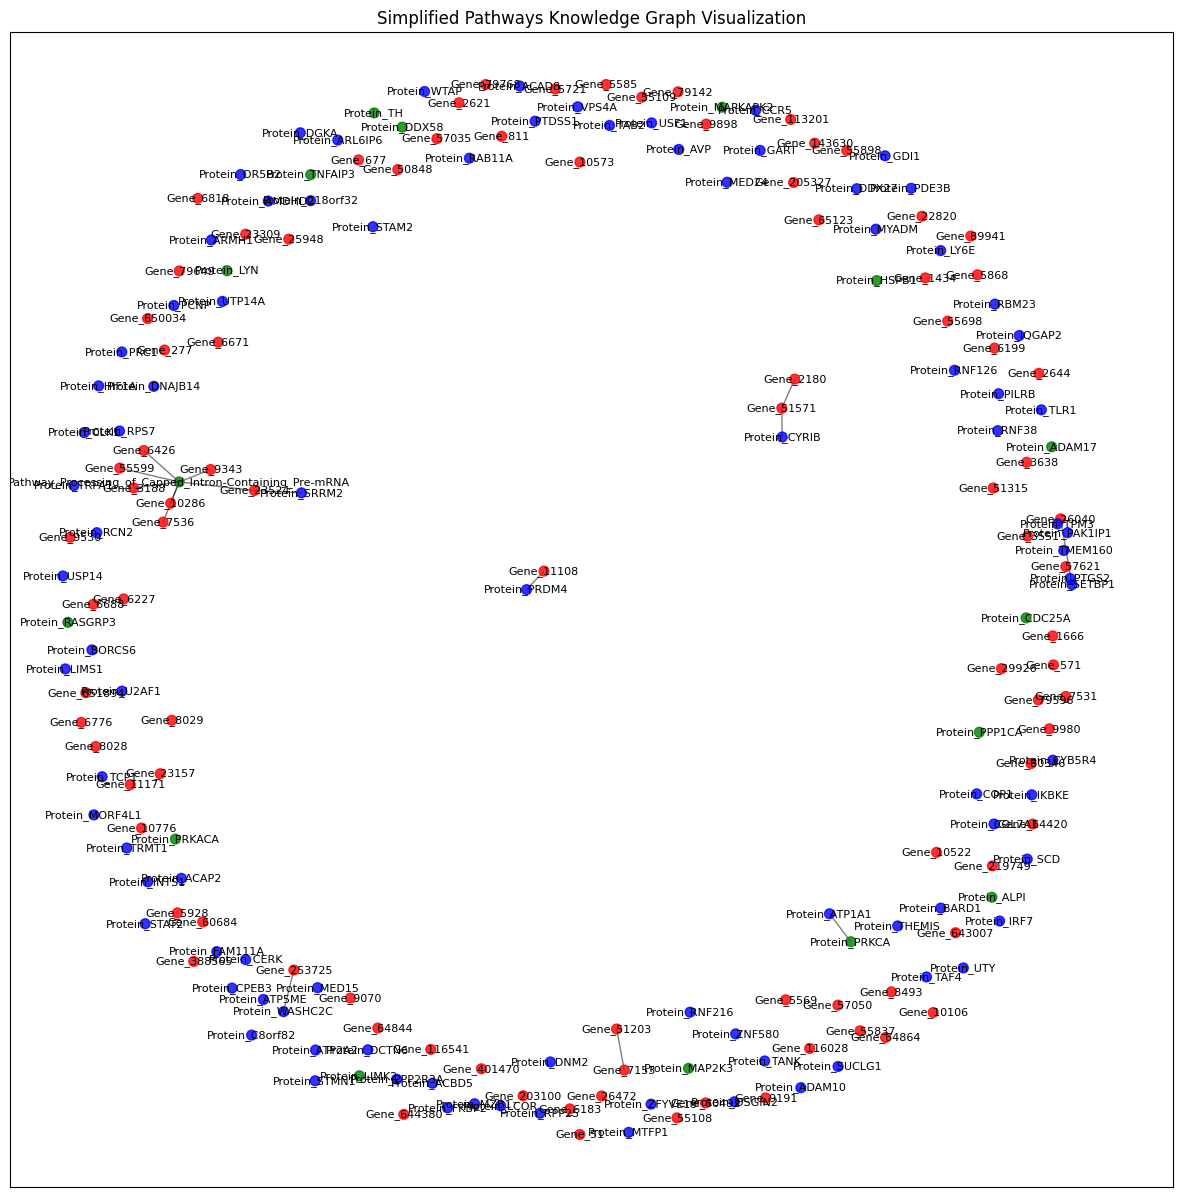

In [ ]:
G = nx.Graph()

for gene in gene_instances.values():
    G.add_node(gene.name, type='Gene')

for protein in protein_instances.values():
    G.add_node(protein.name, type='Protein')

for pathway in pathway_instances.values():
    G.add_node(pathway.name, type='Pathway')

for gene in gene_instances.values():
    for protein in gene.isExpressedBy:
        G.add_edge(gene.name, protein.name)

for gene1, gene2 in co_expression_edges:
    G.add_edge(f"Gene_{gene1}", f"Gene_{gene2}", type='Co-expression')

for index, row in biogrid_interactions.iterrows():
    protein_a = f"Protein_{row['Official Symbol Interactor A']}"
    protein_b = f"Protein_{row['Official Symbol Interactor B']}"
    G.add_edge(protein_a, protein_b, type='PPI')

for index, row in pathway_results.iterrows():
    pathway_name = f"Pathway_{row['name'].replace(' ', '_')}"
    involved_genes = row['intersections']
    for gene in involved_genes:
        G.add_edge(f"Gene_{gene}", pathway_name, type='Pathway')

all_nodes = list(G.nodes)
sampled_nodes = random.sample(all_nodes, min(200, len(all_nodes)))  # Limit to 200 nodes
simplified_G = G.subgraph(sampled_nodes).copy()

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(simplified_G, k=0.15)

node_colors = ['red' if simplified_G.nodes[node].get('type') == 'Gene' else 'blue' if simplified_G.nodes[node].get('type') == 'Protein' else 'green' for node in simplified_G.nodes]
nx.draw_networkx_nodes(simplified_G, pos, node_color=node_colors, alpha=0.8, node_size=50)
nx.draw_networkx_edges(simplified_G, pos, alpha=0.5)
nx.draw_networkx_labels(simplified_G, pos, font_size=8)

plt.title("Simplified Pathways Knowledge Graph Visualization")
plt.show()

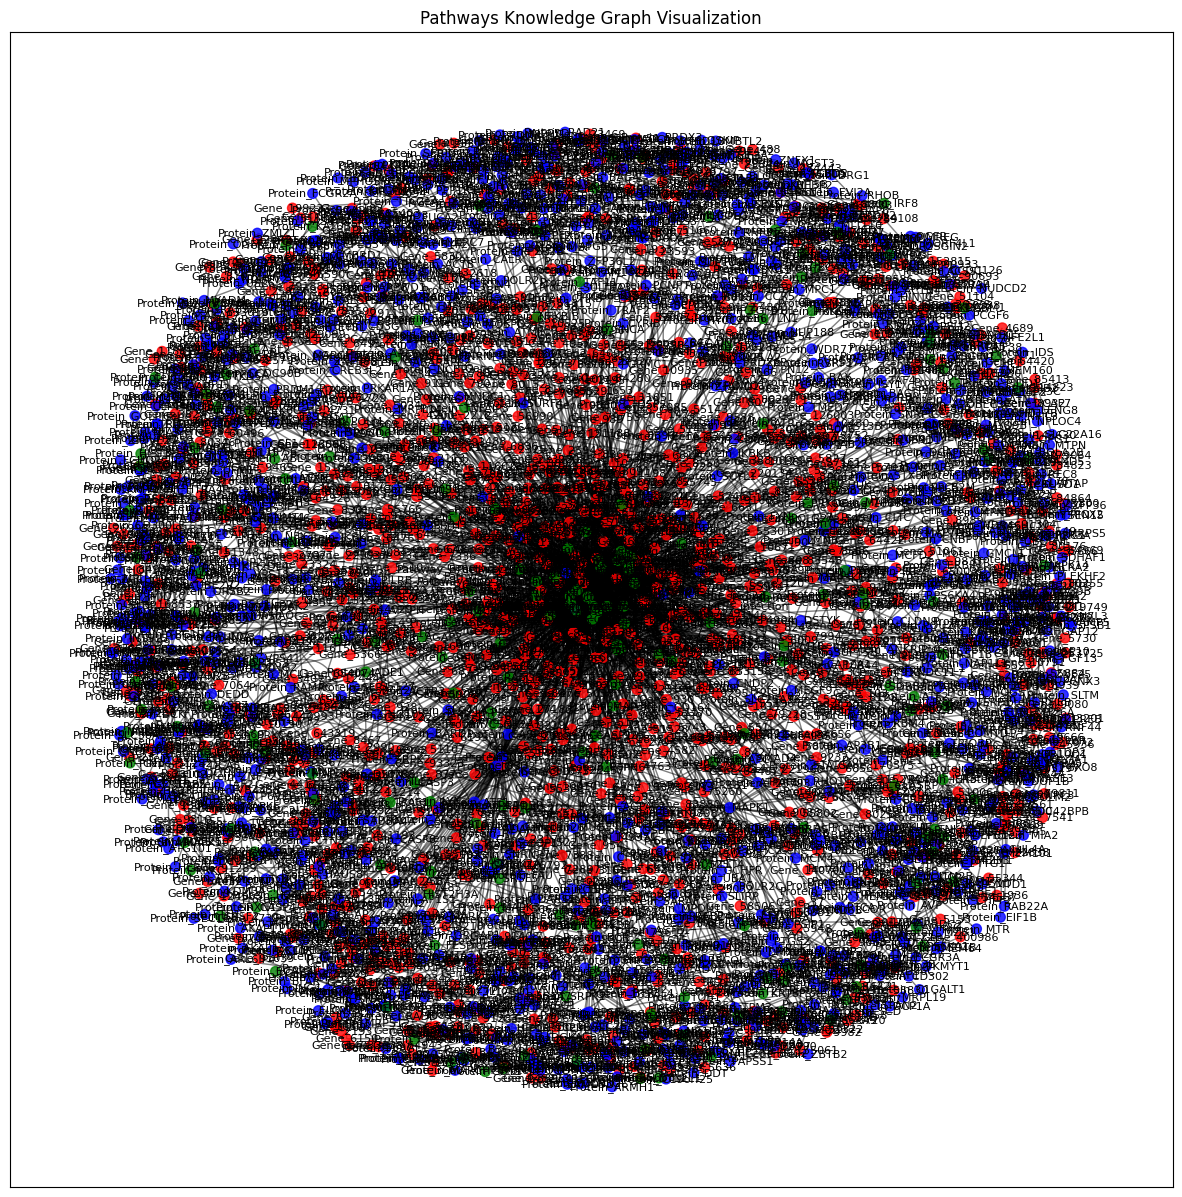

In [ ]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15)

node_colors = ['red' if G.nodes[node].get('type') == 'Gene' else 'blue' if G.nodes[node].get('type') == 'Protein' else 'green' for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Pathways Knowledge Graph Visualization")
plt.show()